# TP2: Plug & Play Algorithms - M2 MVA DeLIReS

<u>*Andrés Almansa - M2 MVA - Deep Learning for Image Restoration and Synthesis*</u>



In this practical session you will experiment with the Plug & Play ADMM and ISTA algorithms presented in the previous lecture, add a new inverse problem to that framework, and experimentally verify the validity of the convergence conditions and results that were presented in class.

As a reference for these results you can refer to the course slides[^1], the references therein, in particular the articles by Ryu *et al.* (2019)[^2] and by Xu *et al.* (2020)[^3].

[^1]: Slides of previous lecture and data for this TP https://partage.imt.fr/index.php/s/orsMzfKCx9dTm6a

[^2]: Ryu, E. K., Liu, J., Wang, S., Chen, X., Wang, Z., & Yin, W. (2019). Plug-and-Play Methods Provably Converge with Properly Trained Denoisers. In *ICML*.  [arXiv:1905.05406](http://arxiv.org/abs/1905.05406)

[^3]: Xu, X., Sun, Y., Liu, J., Wohlberg, B., & Kamilov, U. S. (2020). Provable Convergence of Plug-and-Play Priors with MMSE denoisers. [arXiv:2005.07685](http://arxiv.org/abs/2005.07685)

## Environment setup

To run this practical session (TP) you will need

* python3 
* a few standard python packages like numpy, pytorch, script, matplotlib
* the code provided for this TP

For the python part you need access to a jupyter notebook server either on your local machine, on google colab or on a server provided by your university.

I recommend to use a notebook server that allows the use of a GPU to accelerate calls to the pytorch framework, like Google colab (on which this TP was tested). It will ussually run the CNN-based denoisers much faster.

The specific code for this TP can be obtained (in its original version) from the author's GitHub site:

https://github.com/uclaopt/Provable_Plug_and_Play

A modified code that makes the implementation more modular and makes it easier to switch between CPU and GPU powered servers is available here, along with the code needed to run the TV denoiser:

https://partage.imt.fr/index.php/s/orsMzfKCx9dTm6a
or http://up5.fr/delires2023

Download the notebook and open it with Google colab (or your preferred jupyter notebook server).

Then download the zip file PnP-TP.zip and unzip it into your Google Drive.

Then go to your notebook and run the following code in order to have access to the python code in the zip file (DnCNN and TV denoisers), and to the BM3D denoiser code.

### Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Go to the folder in Google drive where you downloaded the provided code. And check its contents.

In [5]:
%cd /content/drive/My Drive/PnP-TP
!ls ./images
!ls ./utils
!ls -l 

/content/drive/My Drive/PnP-TP


### Check GPU

If a cuda GPU is not available, change the runtime type in the Runtime menu.

In [1]:
!nvidia-smi

Tue Mar 28 21:15:56 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Install required packages

In [2]:
! pip install tifffile

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# Load BM3D denoiser
! pip install bm3d
from bm3d import bm3d, BM3DProfile

class BM3DDenoiser:
    def __init__(self,
        sigma = 40,                  # Noise stdev for an 8-bit image in [0,255]
        rescale = False):             # If true rescale [min,max] to [0,1] before applying denoiser
        self.sigma = sigma/255.0
        self.rescale = rescale
    def denoise(self,xtilde):
        """
        Inputs:
            :xtilde     noisy image
        Outputs:
            :x          denoised image
        """
        # scale xtilde to be in range of [0,1] (for the clean image)
        if self.rescale:
            mintmp = np.min(xtilde)
            #mintmp = 0.0
            maxtmp = np.max(xtilde)
            #maxtmp = 255.0
            xtilde = (xtilde - mintmp) / (maxtmp - mintmp)

        # upgrade to 3D tensor
        xtildeBM3D = np.atleast_3d(xtilde)
        x = bm3d(xtildeBM3D,self.sigma)

        # rescale the denoised v back to original scale
        if self.rescale:
            x = x * (maxtmp - mintmp) + mintmp

        return x



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Test TV and DnCNN denoisers


### Load input image

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff

# Load clean image
# u_total = plt.imread('./images/simpson_nb512.png')
# u_total = tiff.imread('./images/cameraman.tif')
u_total = tiff.imread('./images/barbara.tif')

# Extract a small part
#u = np.zeros((256,256), dtype = np.float64)
#u = u_total[0:256, 0:256]
u = u_total #[100:200,100:200]

# Normalize to [0,1]
maxval = 255.0
minval = 0
u = (u - minval)/(maxval-minval)

### Simulate noisy image

Text(0.5, 1.0, 'Noisy image')

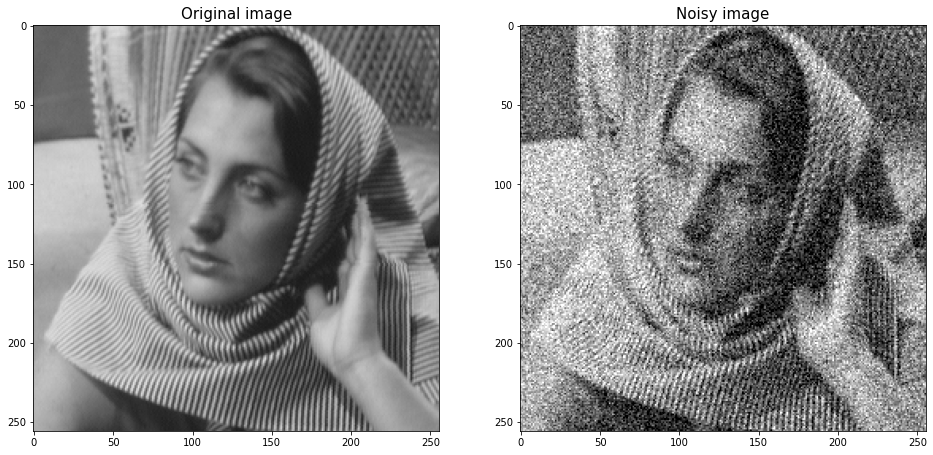

In [8]:
# Use always the same seed for random numbers for reproducibility
np.random.seed(42)

# Simulate noisy image
sigma255 = 40
sigma1 = sigma255/255.0
noise = np.random.normal(loc=0, scale=sigma1, size=(u.shape))
utilde = u + noise

# Show original and noisy images
fig = plt.figure(figsize = (16,16))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(u, cmap = 'gray', vmin=0, vmax = 1)
ax1.set_title('Original image', fontsize = 15)
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(utilde, cmap = 'gray', vmin=0, vmax = 1)
ax2.set_title('Noisy image', fontsize = 15)

### Run TV, DnCNN and BM3D denoisers

Load an input image and add random gaussian noise with $\sigma_{255}=40$, 15 or 5.

Byte-encoded gray-scale images take values in the range [0,255].

But denoising algorithms assume that clean images take values in the range [0,1].

So you need to first normalize your clean and noisy images and sigma values to the range [0,1]:

$u_1 = u_{255}/255$

$\sigma_1 = \sigma_{255}/255$

The DnCNN denoiser can be deployed as is, but for the TV denoising you need to choose the regularization parameter $\lambda$ in

$\hat{u}_\lambda = \arg\min_u \frac{1}{2}\|u-\tilde{u}\|^2 + \lambda TV(u)$

TV Denoiser performance
residual/sigma=0.30	 RMSE=0.1197 (18.4 dB)
DnCNN Denoiser performance
residual/sigma=0.94	 RMSE=0.0450 (26.9 dB)
BM3D Denoiser performance
residual/sigma=0.95	 RMSE=0.0417 (27.6 dB)


Text(0.5, 1.0, 'BM3D denoising')

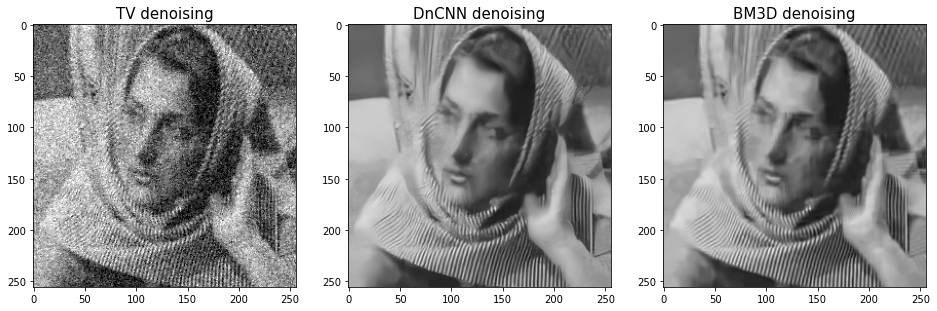

In [9]:
from TV_denoiser import TVDenoiser
from pytorch_denoiser import PyTorchDenoiser

# TV denoiser
TVlamb = sigma1**2
niter = 100
denoiser = TVDenoiser(TVlamb,niter)
uTV = denoiser.denoise(utilde)

# DnCNN denoiser
denoiser = PyTorchDenoiser('DnCNN',sigma255,cuda=True,rescale=False)
uDnCNN = denoiser.denoise(utilde)

# BM3D denoiser With the default settings.
denoiser = BM3DDenoiser(sigma255)
uBM3D = denoiser.denoise(utilde)

# Print performance and plot results
from utils.psnr import rmse, psnr
# printperf(residual, L2err) :
# -- prints out residual/sigma, rmse and psnr values
# peak=np.linalg.norm(u);
peak=1.0
printperf = lambda residual,L2err : print('residual/sigma={:.2f}\t RMSE={:.4f} ({:.1f} dB)'.format(residual,L2err,20*np.log(peak/L2err)/np.log(10)))

print('TV Denoiser performance')
L2err = rmse(uTV,u)
residual = rmse(uTV,utilde)
printperf(residual/sigma1, L2err)

print('DnCNN Denoiser performance')
L2err = rmse(uDnCNN,u)
residual = rmse(uDnCNN,utilde)
printperf(residual/sigma1, L2err)

print('BM3D Denoiser performance')
L2err = rmse(uBM3D,u)
residual = rmse(uBM3D,utilde)
printperf(residual/sigma1, L2err)


# Show denoised images
fig = plt.figure(figsize = (16,16))
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(uTV, cmap = 'gray', vmin=0, vmax = 1)
ax1.set_title('TV denoising', fontsize = 15)
ax2 = fig.add_subplot(1,3,2)
ax2.imshow(uDnCNN, cmap = 'gray', vmin=0, vmax = 1)
ax2.set_title('DnCNN denoising', fontsize = 15)
ax3 = fig.add_subplot(1,3,3)
ax3.imshow(uBM3D, cmap = 'gray', vmin=0, vmax = 1)
ax3.set_title('BM3D denoising', fontsize = 15)


### Find optimal $\gamma$ for TV denoiser

The DnCNN denoiser can be deployed as is (for fixed pretrained noise values), but for the TV denoising you need to choose the regularization parameter $\lambda$ in

$\hat{u}_\lambda = \arg\min_u \frac{1}{2}\|u-\tilde{u}\|^2 + \lambda TV(u)$

Good values for $\lambda$ are usually between $\sigma$ and $\sigma^2$, but this really depends on the image contents: Total variation penalizes high frequency oscilatory patterns, so in those areas a smaller value of $\lambda$ may be required to preserve them.

A way to circumvent this problem is to systematically search for a value of $\lambda$ whose residual is close to the noise level:

$\|\hat{u}_\lambda - \tilde{u}\|^2 \approx \beta^2 \sigma^2 N$

To be conservative (we prefer to leave a bit of noise rather than removing details) we choose a value of $\beta < 1$ like $\beta=0.9$

At each iteration the value of $\lambda$ can be updated in the following manner:

$\lambda_{n+1} = \lambda_n e^{\rho(\sigma\beta - \|\hat{u}_{\lambda_n} - \tilde{u}\|/\sqrt{N})}$

This will increase or decrease $\lambda$ as needed to meet the residual constraint.

You can stop after 100 iterations or when the constraint is met up to 1% tolerance

**Question 1**: Complete the code below as indicated

**Question 2**: Provide the optimal value of $\lambda$ and the RMSEs / PSNRs that you obtain for TV and the different PyTorch denoisers. Which denoiser provides the best performance?

**Question 3**: Is there a big difference between DnCNN and RealSN_DnCNN? Explain why or why not.



Searching for optimal lambda for TV denoising
residual/sigma = 0.295	 rmse = 1.1974e-01	 lambda = 2.3376e-02
TV Denoiser performance
residual/sigma=0.28	 RMSE=0.1214 (18.3 dB)
DnCNN Denoiser performance
residual/sigma=0.94	 RMSE=0.0450 (26.9 dB)


Text(0.5, 1.0, 'DnCNN denoising')

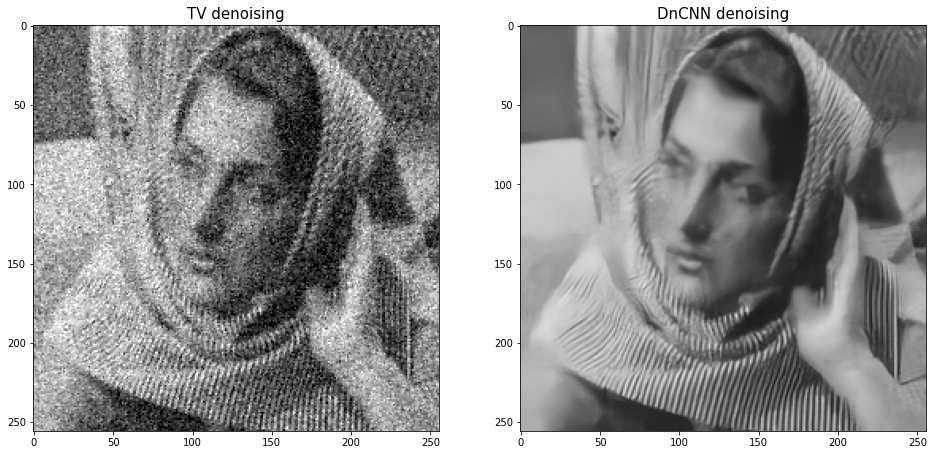

In [10]:
# Optimal lambda
print('Searching for optimal lambda for TV denoising')
TVlamb = sigma1**2
rho = 10
beta = 0.95
for i in range(1,100):
  uTV = TVDenoiser(lamb=TVlamb,niter=100).denoise(utilde)
  res = rmse(uTV,utilde)
  error = rmse(uTV,u)
  TVlamb = TVlamb * beta 
  print('residual/sigma = {:.3f}\t rmse = {:.4e}\t lambda = {:.4e}'.format((res/sigma1),error,TVlamb))
  stop_cond= error < rho * sigma1 
  if stop_cond:
    break

# Denoise
print('TV Denoiser performance')
denoiser = TVDenoiser(TVlamb,100)
uTV = denoiser.denoise(utilde)
L2err = rmse(uTV,u)
residual = rmse(uTV,utilde)
printperf(residual/sigma1, L2err)

print('DnCNN Denoiser performance')
denoiser = PyTorchDenoiser('DnCNN',sigma255,cuda=True,rescale=False)
uDnCNN = denoiser.denoise(utilde)
L2err = rmse(uDnCNN,u)
residual = rmse(uDnCNN,utilde)
printperf(residual/sigma1, L2err)


# Show denoised images
fig = plt.figure(figsize = (16,16))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(uTV, cmap = 'gray', vmin=0, vmax = 1)
ax1.set_title('TV denoising', fontsize = 15)
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(uDnCNN, cmap = 'gray', vmin=0, vmax = 1)
ax2.set_title('DnCNN denoising', fontsize = 15)

## Plug & Play ADMM / DRS for Gaussian denosing

The DnCNN denoiser is pretrained for 3 values of $\sigma \in \{5,15,40\}$. Now we are going to use write an ADMM / DRS splitting algorithm that can denoise images with other noise levels, using the pretrained DnCNN as a regularizer.

The code allows you to solve inverse problems of the form

$
\newcommand{\prox}{{\operatorname{prox}}}
\newcommand{\x}{\mathbf{x}}
\newcommand{\xtilde}{\mathbf{\tilde{x}}}\newcommand{\xhat}{\mathbf{\hat{x}}}
\newcommand{\y}{\mathbf{y}} 
\newcommand{\z}{\mathbf{z}} 
\newcommand{\v}{\mathbf{v}} 
\newcommand{\w}{\mathbf{w}} 
\xhat = \arg\min_\x F(\x) + \gamma G(\x)$

or equivalently for $\gamma = \sigma^2/\alpha$

$\xhat = \arg\min_\x \alpha F(\x) + \sigma^2 G(\x)$


where $F$ is a ($\mu$-strongly) convex data-fitting term, and $G$ is a possibly non-convex regularisation term, which is not necessarily known explicitly. We only need to know its associated proximal operator
$\prox_{\sigma^2 G}(\x) \approx D_\sigma(\x)$, which is well approximated by the DnCNN denoiser.

The code will compute the Plug & Play ADMM algorithm to find $\xhat$. According to Theorem 2 and Corolary 3 this algorithm will converge as long as the residual operator $D_\sigma - I$ is $\varepsilon$-Lipschitz (or $\varepsilon$-contractive) with $\varepsilon<1$, and the $\alpha$ parameter satisfies

$\alpha \mu > \frac{\varepsilon}{1+\varepsilon - 2\varepsilon^2}$

### Proximal operator for Gaussian denoising

For Gaussian denoising the data fitting term writes

$ F(\x) = \frac{1}{2 s^2}\| \x - \y \|^2 $

its proximal operator admits a closed form:

$ \prox_{\alpha F}(\x) = \arg\min_\v \frac12 \|\v - \x \|^2 + \alpha F(\v)
= \frac{\x + \y * \alpha / s^2}{1+\alpha/s^2}$

_**QUESTION 4**: Complete the following code to compute $\prox_{\alpha F}$ operator for Gaussian denoising._

In [11]:
#%% ---- define problem-specific proxF ----

def prox_datafit_gaussian_denoising(x, y, alpha, s):
    """
    Proximal Operator for Gaussian denoising:

    f(x) = || x - y ||^2 / (2 s^2)

    prox_{alpha f} (x) = (x + y*alpha/s^2)/(1+alpha/s^2)

    Parameters:
        :x - the argument to the proximal operator.
        :y - the noisy observation (flattened).
        :opts - the kwargs for hyperparameters.
            :alpha - the value of alpha.
            :s - the standard deviation of the gaussian noise in y.
    """
    a = alpha/(s**2)
    v = (x + y * a) / (1 + a)
    return v




### PnP DRS denoising experiment with $s = \sigma$

Now use the profided PnP DRS algorithm to denoise an image with noise variance $s^2 = \sigma^2$.

In this case you should use the regularization parameter $\gamma = 1$.

i = 1,	 psnr = 26.965323130272235,	 fpr = 0.14760314073924402
i = 2,	 psnr = 26.965323130272235,	 fpr = 0.07380157036962201
i = 3,	 psnr = 26.965323130272235,	 fpr = 0.036900785184811005
i = 4,	 psnr = 26.965323130272235,	 fpr = 0.018450392592405503
i = 5,	 psnr = 26.965323130272235,	 fpr = 0.00922519629620275
i = 6,	 psnr = 26.965323130272235,	 fpr = 0.004612598148101376
i = 7,	 psnr = 26.965323130272235,	 fpr = 0.002306299074050688
i = 8,	 psnr = 26.965323130272235,	 fpr = 0.001153149537025344
i = 9,	 psnr = 26.965323130272235,	 fpr = 0.000576574768512672
i = 10,	 psnr = 26.965323130272235,	 fpr = 0.000288287384256336
i = 11,	 psnr = 26.965323130272235,	 fpr = 0.000144143692128168
i = 12,	 psnr = 26.965323130272235,	 fpr = 7.2071846064084e-05
i = 13,	 psnr = 26.965323130272235,	 fpr = 3.6035923032042e-05
i = 14,	 psnr = 26.965323130272235,	 fpr = 1.8017961516020995e-05
i = 15,	 psnr = 26.965323130272235,	 fpr = 9.008980758010504e-06
i = 16,	 psnr = 26.965323130272235,	 fpr = 4.504490

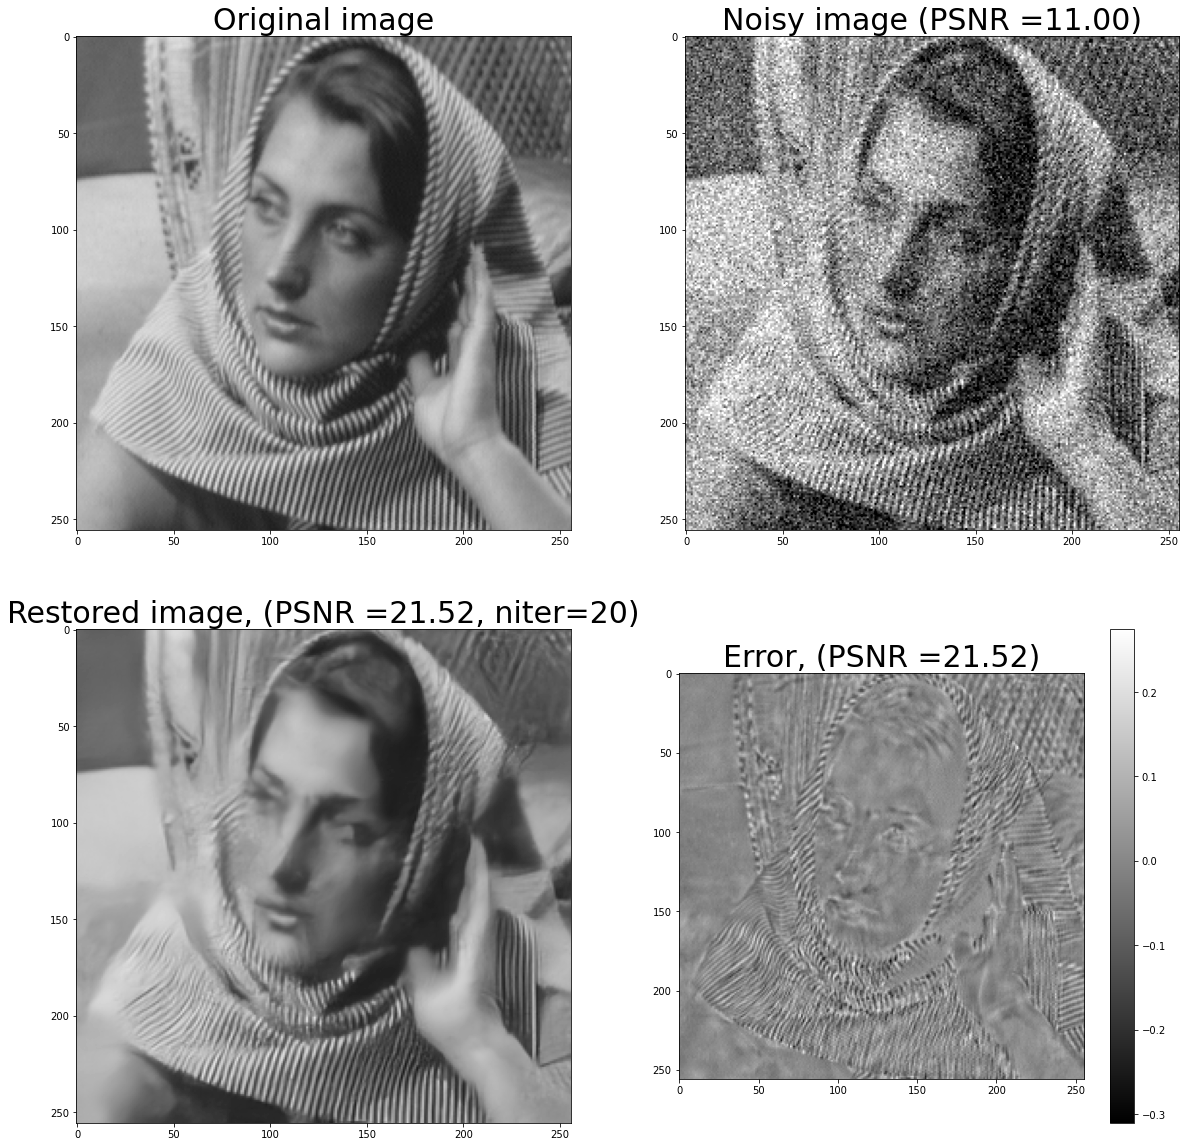

In [12]:
# ---- Regularization model prox_{sigma^2 G} = denoise ----
# noise level
sigma255 = 40             # for uint8 images
sigma1 = sigma255/255.0   # for images normalized in [0,1]
# load pretrained denoiser NN model into Denoiser object
model_type = "RealSN_DnCNN"     # Alternatives: DnCNN/ SimpleCNN / RealSN_DnCNN / RealSN_SimpleCNN
sigma = sigma255                # Alternatives: 5, 15, 40
cuda = True                     # If true use pytorch cuda optimisations
rescale = False                 # If true rescale [min,max] to [0,1] before applying denoiser
Denoiser = PyTorchDenoiser(model_type,sigma,cuda,rescale)
# define denoise(x) function (as a call to the Denoiser object)
denoise = lambda x : Denoiser.denoise(x)

# ADMM / DRS parameters
gamma = 1.0                       # Regularization parameter
alpha = sigma1**2/gamma
maxitr = 20                     # ADMM max number of iterations
# Monitors
verbose = 1                     # display debugging messages

s = sigma1

# Datta fitting : prox_{alpha F}
proxF = lambda x : prox_datafit_gaussian_denoising(x, utilde, alpha, s)


# PnP DRS
from optim import drs, GaussianMonitor
monitor = GaussianMonitor(u) # ground truth is only used
                             # to track PSNR during iterations


# optional PnP DRS/ADMM parameters
opts = dict(maxitr=maxitr,
            verbose=verbose,
            monitor=monitor)


# ---- simulate noisy image ----
np.random.seed(42) # Use always the same seed for reproducibility
s = sigma1
noise = np.random.normal(loc=0, scale=s, size=(u.shape))
utilde = u + noise


# Start the algorithm
#start = time.time()
init = utilde
#init = np.random.normal(loc=0.5, scale=0.5, size=(noisy.shape))
out = drs(proxF,denoise,init,**opts)
#out = admm(proxF,denoise,init,**opts)
#end = time.time()
#print(end-start)

#%% ---- plot result ----
fig = plt.figure(figsize = (20,20))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(u, cmap = 'gray', vmin=0, vmax = 1)
ax1.set_title('Original image', fontsize = 30)
    
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(utilde, cmap = 'gray', vmin=0, vmax = 1)
ax2.set_title('Noisy image (PSNR ={0:.2f})'.format(psnr(u, utilde)), fontsize = 30)

ax3 = fig.add_subplot(2,2,3)
ax3.imshow(out, cmap ='gray', vmin= 0, vmax=1)
ax3.set_title(r'Restored image, (PSNR ={0:.2f}, niter={1})'.format(psnr(u, out),maxitr), fontsize = 30)

ax4 = fig.add_subplot(2,2,4)
p = ax4.imshow(out-u, cmap ='gray')
plt.colorbar(p,orientation='vertical')
_ = ax4.set_title(r'Error, (PSNR ={0:.2f})'.format(psnr(u, out)), fontsize = 30)



### PnP DRS denoising experiment with $s \neq \sigma$

Now use the profided PnP DRS algorithm to denoise an image with noise variance $s^2 \neq \sigma^2$.

In this case the regularization parameter $\gamma$ needs to be adapted to find the optimal value.

_**QUESTION 5:** Take $s=30$ and use the same strategy as for TV denoising to search for the optimal $\gamma$ for $\sigma=5, 15, 40$. Make a table with the optimal values of $\gamma$ for each $\sigma$ and the corresponding PSNRs._
1. _What is the maximum value of $\gamma$ that ensures convergence?_
2. _Is convergence guaranteed in all cases? Which ones?_
3. _Which value of $\sigma$ provides the best results? Can you explain why?_

A partial answer to the convergence analysis is provided in the celle below

_**QUESTION 6:** Compare the results obtained with RealSN_DnCNN and with DnCNN, TV and BM3D. Which one provides the best performance? Can you explain why?_

_**QUESTION 7:** Test different initialisations, including 0 and random images. How important is the initialization to obtain a good result? Is this consistent with the convergence results seen in the Lecture ?_


| $\sigma$ | $\gamma$ | PSNR |
| -------- | -------- | ---- |
| 40 | 1.36 | 22.91 dB |


i = 1,	 psnr = 18.828554251340183,	 fpr = 0.0055551238840881745
i = 2,	 psnr = 18.995880805934892,	 fpr = 0.0036037926906365763
i = 3,	 psnr = 19.13888082981462,	 fpr = 0.002797879889592865
i = 4,	 psnr = 19.26323370839911,	 fpr = 0.0023370074031700237
i = 5,	 psnr = 19.372138922739325,	 fpr = 0.0019963734385583
i = 6,	 psnr = 19.467834340703366,	 fpr = 0.001724662758715522
i = 7,	 psnr = 19.552105568560627,	 fpr = 0.0015005768779573344
i = 8,	 psnr = 19.626437283472256,	 fpr = 0.0013121489050266838
i = 9,	 psnr = 19.692076473796945,	 fpr = 0.0011514913488991565
i = 10,	 psnr = 19.750089294368724,	 fpr = 0.00101307919814623
i = 11,	 psnr = 19.801396039290232,	 fpr = 0.0008932224246985924
i = 12,	 psnr = 19.84679688310798,	 fpr = 0.0007889845656362227
i = 13,	 psnr = 19.88699317189482,	 fpr = 0.0006979866698612005
i = 14,	 psnr = 19.92259957077042,	 fpr = 0.0006184187590554074
i = 15,	 psnr = 19.954153414298403,	 fpr = 0.0005486821148207537
i = 16,	 psnr = 19.982127077803135,	 fpr = 0.0

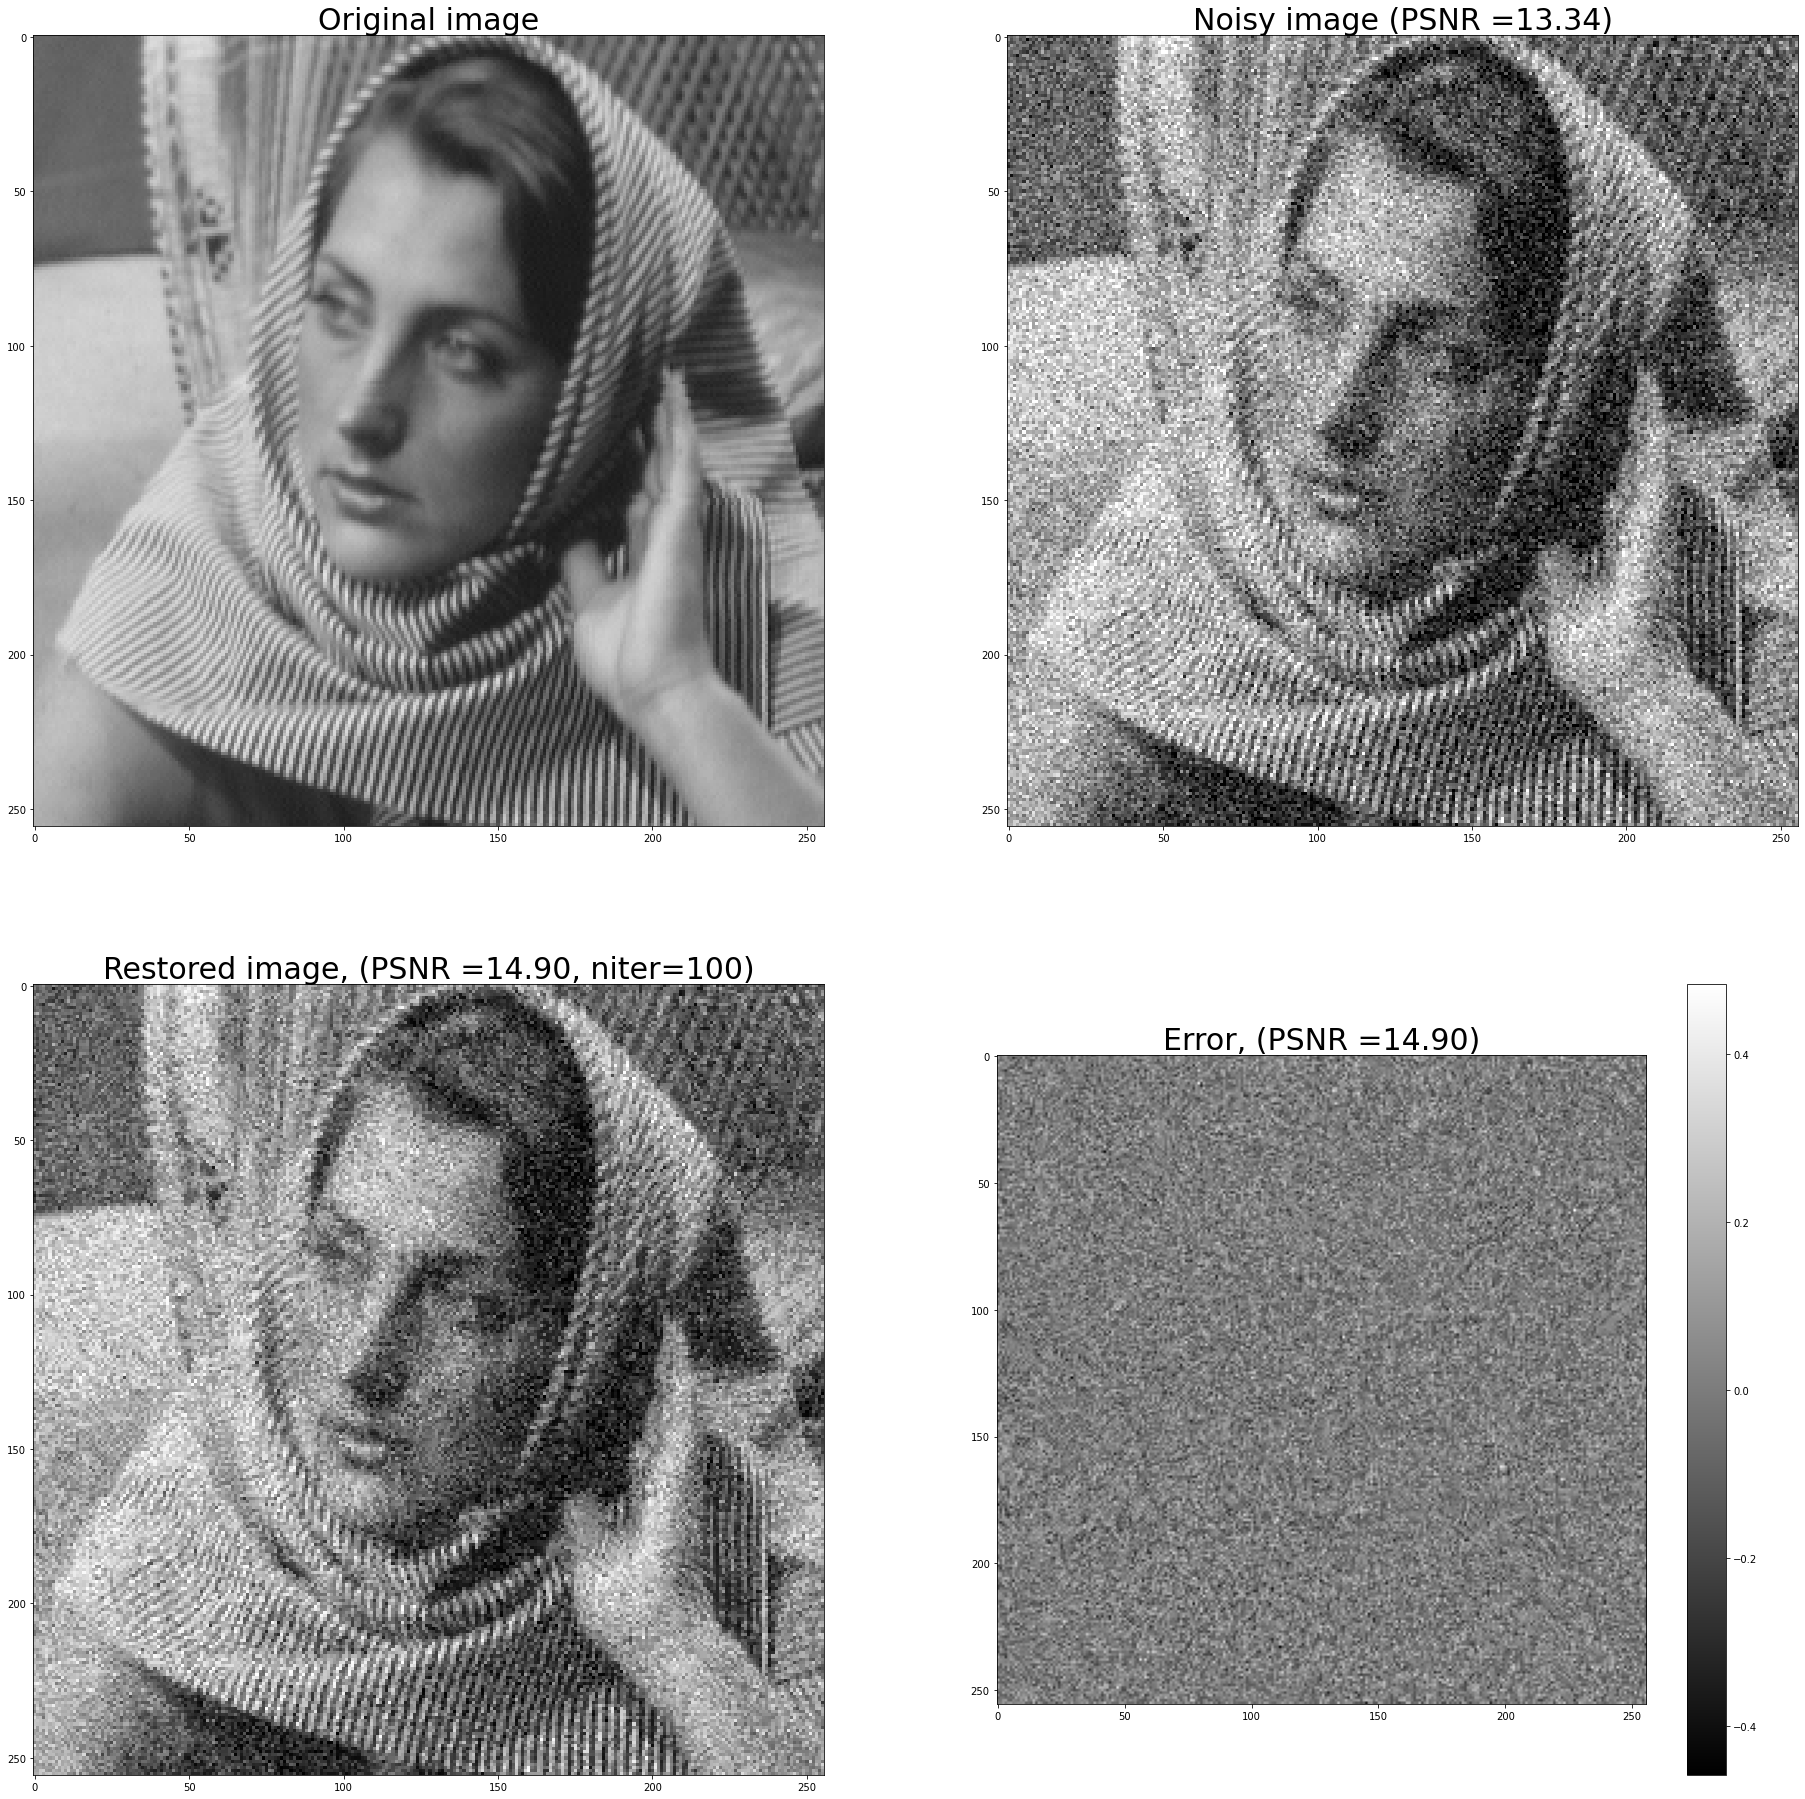

In [13]:
# u = normalized input image (defined above)

# ---- Degradation model F (white gaussian noise) ----
s = 30.0
s1 = s / (maxval-minval)
np.random.seed(42)
noise = np.random.normal(loc=0, scale=s1, size=(u.shape))
utilde = u + noise


# ---- Regularization model prox_{sigma^2 G} = denoise ----
# noise level
sigma255 = 5             # for uint8 images
sigma1 = sigma255/255.0   # for images normalized in [0,1]
# load pretrained denoiser NN model into Denoiser object
model_type = "RealSN_DnCNN"     # Alternatives: DnCNN/ SimpleCNN / RealSN_DnCNN / RealSN_SimpleCNN
sigma = sigma255                # Alternatives: 5, 15, 40
cuda = True                     # If true use pytorch cuda optimisations
rescale = False                 # If true rescale [min,max] to [0,1] before applying denoiser
# pytorch deoiser
Denoiser = PyTorchDenoiser(model_type,sigma,cuda,rescale)
# define denoise(x) function (as a call to the Denoiser object)
denoise = lambda x : Denoiser.denoise(x)



# ADMM / DRS parameters
gamma = sigma1/s1                   # Regularization parameter
alpha = sigma1**2/gamma
maxitr = 100                    # ADMM max number of iterations
# Monitors
verbose = 0                     # display debugging messages

proxF = lambda x : prox_datafit_gaussian_denoising(x, utilde, alpha, s1)


# COMPLETE THE CODE
# find optimal gamma
# compute out = result of PnP ADMM denoising
# repeat for sigma255 = 40, 15, 5

opts = dict(maxitr=maxitr, verbose=1, monitor=GaussianMonitor(u))
out = drs(proxF,denoise,utilde,**opts)


#%% ---- plot result ----
fig = plt.figure(figsize = (32,32))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(u, cmap = 'gray', vmin=0, vmax = 1)
ax1.set_title('Original image', fontsize = 30)
    
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(utilde, cmap = 'gray', vmin=0, vmax = 1)
ax2.set_title('Noisy image (PSNR ={0:.2f})'.format(psnr(u, utilde)), fontsize = 30)

ax3 = fig.add_subplot(2,2,3)
ax3.imshow(out, cmap ='gray', vmin= 0, vmax=1)
ax3.set_title(r'Restored image, (PSNR ={0:.2f}, niter={1})'.format(psnr(u, out),maxitr), fontsize = 30)

ax4 = fig.add_subplot(2,2,4)
p = ax4.imshow(out-u, cmap ='gray')
plt.colorbar(p,orientation='vertical')
_ = ax4.set_title(r'Error, (PSNR ={0:.2f})'.format(psnr(u, out)), fontsize = 30)


### Check convergence conditions

The PnP-ADMM algorithm for minimizing $\alpha F(x) + \sigma^2 G(x)$ is guaranteed to converge to a fixed point as long as:
* $F$ is $\mu$-strongly convex
* $Lip(I-D) = \varepsilon < 1$ where $D=\prox_{\sigma^2 G}$ is the denoiser
* The regularization parameter $\gamma = \sigma^2/\alpha$ satisfies
$$ \gamma < \mu \sigma^2 \frac{1+\varepsilon - 2 \varepsilon^2}{\varepsilon}$$

For the denoising problem we have
$$ F(x) = \frac{\|x - y\|^2}{2s^2} $$

**Find the maximal value of $\mu$ such that $F$ is $\mu$ strongly convex**

$F$ is $\mu$-strongly convex if $\nabla^2 F - \mu Id$ is positive semidefinite $(\frac{1}{s^2}-\mu)Id)$ posite semidefinite. $\mu = \frac{1}{s^2}$

The _estimated_ value of $Lip(I-D) = \varepsilon$ for the different denoisers is, according to Ryu(2019, Figure 1)

| $D$   | $\varepsilon$ |
| ----- | ---------- |
| RealSN_DnCNN | 0,464 |
| DnCNN | 0,484 |
| BM3D  | 1,198 | 

You can write a variant of the DRS algorithm which tracks the expansion factor at each iteration of the of the PnP-DRS algorithm.
Let $T$ be the operator that computes one iteration of PnP-DRS.

$$ u_{k+1} = T(u_k) $$

The algorithm converges to a fixed point $u^*$ if $T(u^*)=u^*$.
This convergence is ensures as long as $T$ is nonexpansive meaning that

$$ \|T(x) - T(y)\| \leq \varphi \|x-y\| \quad \forall x, y \quad \text{ and } \varphi <1 $$

The expansion factor $\varphi$ can be estimated as the maximal value of

$$ \varphi_k = \|T(x_k) - T(x_{k-1}) \| / \|x_k - x_{k-1}\| $$

$x_k = T(x_{k-1})$

complete the code below to output an array factors with these estimates



In [14]:

def drs2(proxF,proxG,init,**opts):
    """
    Douglas Rachford Splitting (notation differs from Ryu's paper as follows)
    zk     = x_old + u_old
    xk+1/2 = v
    xk+1   = x
    This variant tracks the contraction factors at each iteration
    """

    """ Process parameters. """
    maxitr = opts.get('maxitr', 50)
    verbose = opts.get('verbose', 1)
    monitor  = opts.get('monitor', None)  # debugging messages


    """ Initialization. """

    n = init.size  # == np.prod(init.shape), i.e. number of elements in ndarray

    x = np.copy(init)
    v = np.zeros_like(init, dtype=np.float64)
    u = np.zeros_like(init, dtype=np.float64)
    x_old = np.zeros_like(init, dtype=np.float64)

    factors = np.zeros([maxitr-1], dtype=np.float64)

    """ Main loop. """

    for i in range(maxitr):

        # record the variables in the current iteration
        x_older = np.copy(x_old)
        x_old = np.copy(x)
        v_old = np.copy(v)
        u_old = np.copy(u)

        """ proximal step. """

        v = proxF(x+u)
        # prox_poisson_datafit(x+u,noisy,lam)

        """ denoising step. """

        xtilde = np.copy(2*v - x_old - u_old)
        #x = denoiser(np.reshape(xtilde, (m,n)))
        #x = np.reshape(x, -1)
        x = proxG(xtilde)

        """ dual update """

        u = np.copy(u_old + x_old - v)

        """ Monitors """

        if verbose and not (monitor is None) :
            monitor.drs_iter(i,x,v,u,x_old,v_old,u_old)

        if (i>0):
          factors[i-1]= np.linalg.norm(x-x_old)/np.linalg.norm(x_old-x_older)

    """ Get restored image. """
    #x = np.reshape((x) , (m, n))
    return x , factors




# u = normalized input image (defined above)

# ---- Degradation model F (white gaussian noise) ----
s = 30.0
s1 = s / (maxval-minval)
np.random.seed(42)
noise = np.random.normal(loc=0, scale=s1, size=(u.shape))
utilde = u + noise


# ---- Regularization model prox_{sigma^2 G} = denoise ----
# noise level
sigma255 = 5             # for uint8 images
sigma1 = sigma255/255.0   # for images normalized in [0,1]
# load pretrained denoiser NN model into Denoiser object
model_type = "RealSN_DnCNN"     # Alternatives: DnCNN/ SimpleCNN / RealSN_DnCNN / RealSN_SimpleCNN
#model_type = "DnCNN"     # Alternatives: DnCNN/ SimpleCNN / RealSN_DnCNN / RealSN_SimpleCNN
sigma = sigma255                # Alternatives: 5, 15, 40
cuda = True                     # If true use pytorch cuda optimisations
rescale = False                 # If true rescale [min,max] to [0,1] before applying denoiser
# Pytorch denoiser
Denoiser = PyTorchDenoiser(model_type,sigma,cuda,rescale)
# BM3D denoiser
# Denoiser = BM3DDenoiser(sigma255)
# define denoise(x) function (as a call to the Denoiser object)
denoise = lambda x : Denoiser.denoise(x)


# ADMM / DRS parameters
gamma0 = sigma1/s1                   # Regularization parameter
alpha = sigma1**2/gamma
maxitr = 20                    # ADMM max number of iterations
# Monitors
verbose = 0                     # display debugging messages

proxF = lambda x : prox_datafit_gaussian_denoising(x, noisy, alpha, s1)


# Maximal (theoretical) gamma
mu = 1.0/(s1**2)
eps = 0.464 # RealSN_DnCNN
#eps = 1.198 # BM3D
gamma_max = mu*(sigma1**2)*(1.0+eps-2*(eps**2))/eps

# geometric mean
gmean = lambda a: np.exp(np.mean(np.log(a)))

init = utilde
print('Theoretical gamma max = {:.3e}'.format(gamma_max))
# test a few gammas around the approximately optimal gamma
for factor in np.geomspace(1/4,16,num=10):
  gamma = gamma0 * factor
  alpha = sigma1**2/gamma
  opts = dict(maxitr=maxitr, verbose=0, monitor=None)
  # Datta fitting : prox_{alpha F}
  proxF = lambda x : prox_datafit_gaussian_denoising(x, utilde, alpha, s1)
  out,factors = drs2(proxF,denoise,init,**opts)
  res = rmse(out,utilde)
  error = rmse(out,u)
  gamma = gamma*np.exp(rho*(s1*beta-res))
  print('residual/sigma = {:.3f}\t rmse = {:.3e}\t gamma = {:.3e}\t max eps = {:.2f}\t mean eps = {:.2f}'.format((res/s1),error,gamma,np.max(factors),gmean(factors)))
  stop_cond = (np.abs(s1*beta-res)<s1*0.005)
  if stop_cond:
    break


Theoretical gamma max = 6.187e-02
residual/sigma = 0.062	 rmse = 1.129e-01	 gamma = 1.184e-01	 max eps = 0.60	 mean eps = 0.56
residual/sigma = 0.087	 rmse = 1.103e-01	 gamma = 1.825e-01	 max eps = 0.72	 mean eps = 0.68
residual/sigma = 0.128	 rmse = 1.059e-01	 gamma = 2.761e-01	 max eps = 0.81	 mean eps = 0.77
residual/sigma = 0.195	 rmse = 9.924e-02	 gamma = 4.053e-01	 max eps = 0.89	 mean eps = 0.85
residual/sigma = 0.292	 rmse = 8.998e-02	 gamma = 5.734e-01	 max eps = 0.96	 mean eps = 0.91
residual/sigma = 0.415	 rmse = 7.935e-02	 gamma = 7.885e-01	 max eps = 1.01	 mean eps = 0.95
residual/sigma = 0.538	 rmse = 6.951e-02	 gamma = 1.082e+00	 max eps = 1.04	 mean eps = 0.98
residual/sigma = 0.640	 rmse = 6.201e-02	 gamma = 1.524e+00	 max eps = 1.06	 mean eps = 1.00
residual/sigma = 0.711	 rmse = 5.701e-02	 gamma = 2.225e+00	 max eps = 1.07	 mean eps = 1.01
residual/sigma = 0.755	 rmse = 5.390e-02	 gamma = 3.353e+00	 max eps = 1.07	 mean eps = 1.01


### PnP ADMM algorithm

_**QUESTION 8:**_

_a) write the ADMM algorithm to solve $\xhat = \arg\min_\x F(\x) + G(\x)$ given the proximal operators of $F$ and $G$. (You can use the provided Douglas Rachford algorithm, which is very similar and equivalent to ADMM, or the code squeleton below)._

_b) A renaming of variables with a reordering of the three updates allows to show the equivalence of ADMM and DRS. Prove this equivalence._




In [15]:
def admm(proxF,proxG,init,**opts):
    """
    ADMM - min_x F(x) + G(x) by ADMM splitting
    Inputs:
        :proxF      Proximal operator of F
        :proxG      Proximal operator of G
        :init       Initial value of x
    Optional inputs
        :maxitr     default 50
        :verbose    default 1 (show messages)
        :monitor    default None
    Outputs
        :x          minimizer
    """

    """ Process parameters. """
    maxitr = opts.get('maxitr', 50)
    verbose = opts.get('verbose', 1)
    monitor  = opts.get('monitor', None)  # debugging messages


    """ Initialization. """

    n = init.size  # == np.prod(init.shape), i.e. number of elements in ndarray

    y = np.copy(init)
    x = np.zeros_like(init, dtype=np.float64)
    u = np.zeros_like(init, dtype=np.float64)

    """ Main loop. """

    for i in range(maxitr):

        # record the variables in the current iteration
        x_old = np.copy(x)
        y_old = np.copy(y)
        u_old = np.copy(u)

        """ denoising step. """

        # COMPLETE THIS CODE
        x = proxG(y - u)

        """ proximal step. """

        # COMPLETE THIS CODE
        y = proxF(2 * x - x_old) + x - x_old
        """ dual update """

        # COMPLETE THIS CODE
        u += x - y 
         
        """ Monitors """

        if verbose and not (monitor is None) :
            monitor.admm_iter(i,x,y,u,x_old,y_old,u_old)

    """ Get restored image. """
    return x


### ANSWER###
b)
The equivalence between ADMM and Douglas-Rachford splitting (DRS) can be shown by renaming variables and reordering the updates in ADMM.

In ADMM, the iterative updates are given as:

    x-update: x = proxF(y-u)
    y-update: y = proxG(x+u)
    u-update: u = u + x - y

By renaming the variables and reordering the updates, the same iterative process can be written as:

    z1-update: z1 = 2 proxF(y) - y
    z2-update: z2 = 2 proxG(x) - x
    x-update: x = (z1 + z2)/2
    y-update: y = y + z1 - x

This process is equivalent to the Douglas-Rachford splitting algorithm, where the proximal operators of F and G are used to update two intermediate variables, z1 and z2, which are then combined to find the final solution x.


## Missing Pixels

Another common inverse problem is missing pixels where the observation model is

$$ y_i = m_i x_i + n_i$$

where $m_i ~ Ber(p)$ is known
and $n_i \sim \mathcal{N}(0,s^2)$ is unknown.

For a random selection of $p=10\%$ of the pixels $m_i=1$ and the pixel value $x_i$ is corrupted by white gaussian noise with a small variance $s^2$.
For the remaining $90\%$ of the pixels $x_i$ is completely unknown.

_**QUESTION 9:** Write the potential and the proximal operator for this degradation (it has a closed form), and solve the inverse problem using PnP-ADMM as before._



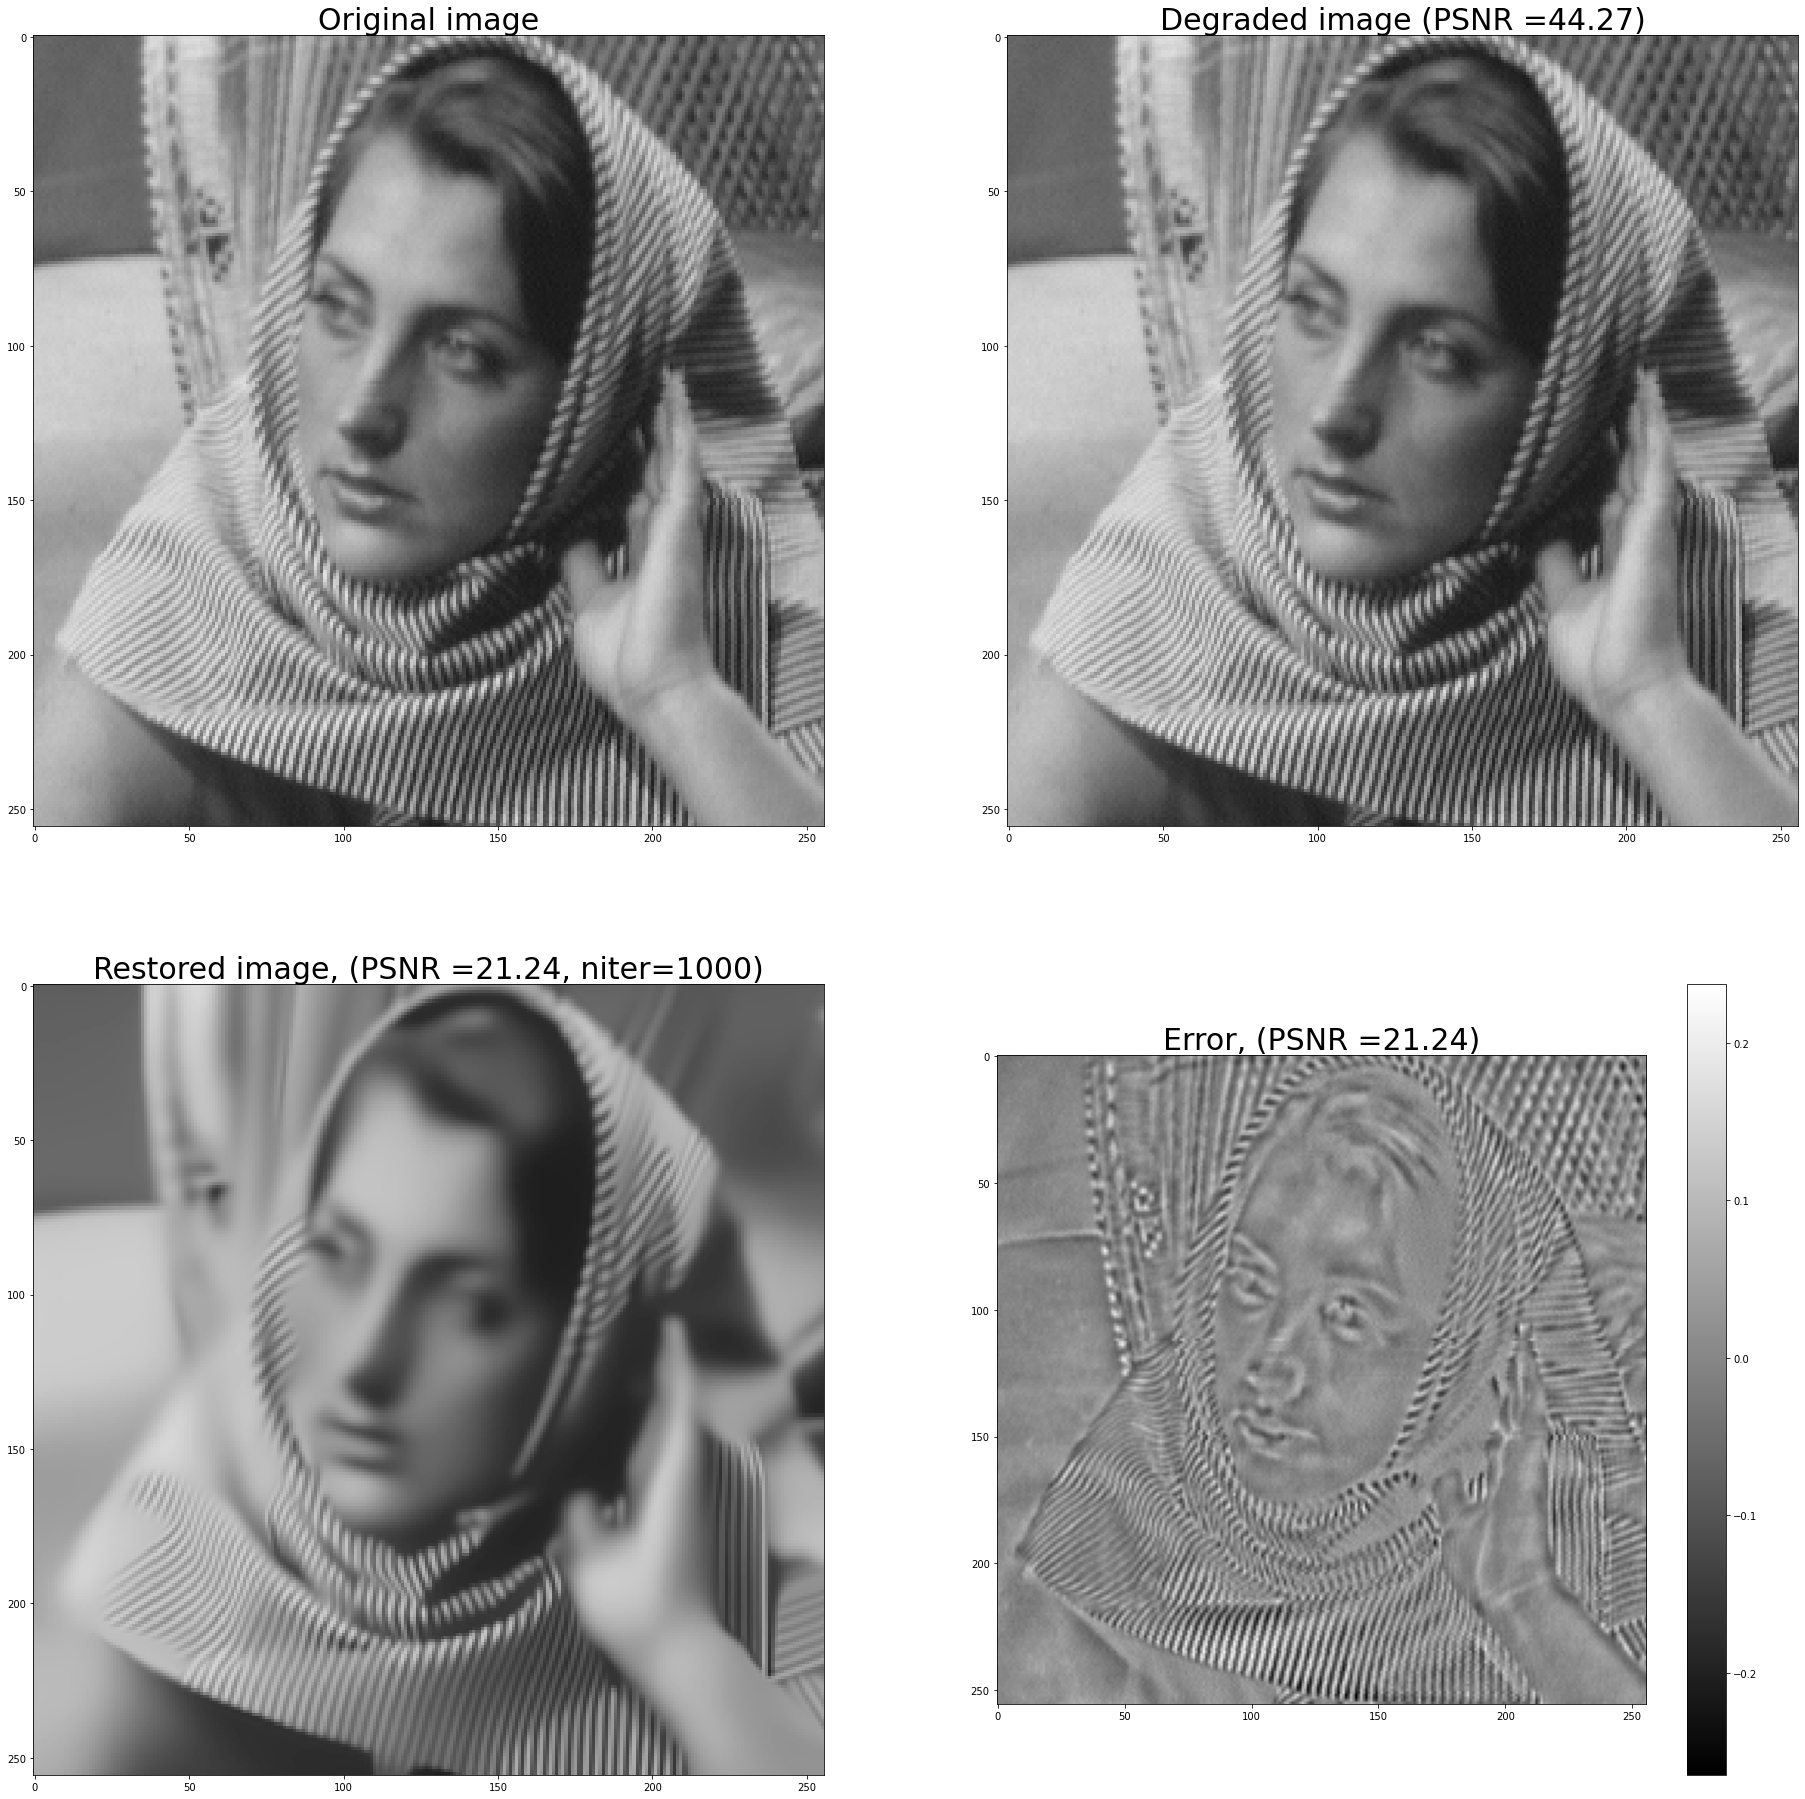

In [16]:
#%% ---- define problem-specific proxF ----

def prox_datafit_inpainting(x, y, mask, alpha, s):
    """
    Proximal Operator for Gaussian denoising:

    f(x) = || M*x - y ||^2 / (2 s^2)

    prox_{alpha f} (x[i]) = (x[i]*s^2 + y[i]*alpha)/(s^2+alpha) if M[i]==1
                          = x[i]                                if M[i]==0

    Parameters:
        :x - the argument to the proximal operator.
        :y - the noisy observation.
        :mask - binary image of the same size as x
        :opts - the kwargs for hyperparameters.
            :alpha - the value of alpha.
            :s - the standard deviation of the gaussian noise in y.
    """
    s2 = (s**2)
    v = np.where(mask == 1, (x * s2 + y * alpha) / (s2 + alpha), x)
    return v


#%% ---- define problem-specific monitor ----

#from skimage.measure import compare_psnr
from utils.psnr import rmse, psnr

class InpaintingMonitor:
    def __init__(self,clean,mask,sigma):
        self.clean = clean
        self.mask = mask
        self.sigma = sigma
    def drs_iter(self,i,x,v,u,x_old,v_old,u_old):
        fpr = np.sqrt(np.sum(np.square((x + u - x_old - u_old)))/x.size)
        error_in_mask = np.sqrt(np.sum(np.square(mask*(x-self.clean)))/(np.sum(mask)))
        psnrs = psnr(x, self.clean, 1.0)
        if i%50==-1%50:
            print("i = {},\t psnr = {:.2f}, fpr = {:.2f}, error in mask = {:.2f}".format(i+1, psnrs, fpr, error_in_mask))
    admm_iter = drs_iter
#monitor = InpaintingMonitor(im,mask,sigma1)


# COMPLETE THIS CODE
# load image u
# simulate degraded image utilde (noise with standard deviation $s = 1/255$)
# restore u with PnP ADMM seeking for the optimal \gamma

# Load image u
u = tiff.imread('./images/barbara.tif')
u = u.astype(np.float64) / 255

# Simulate degraded image utilde
s = 1 / 255
np.random.seed(0)
noise = s * np.random.randn(*u.shape)
mask = np.random.rand(*u.shape) < 0.7
utilde = np.where(mask, u + noise, u)

# Restore u with PnP ADMM
gamma = 0.1 # Choose a suitable value for gamma
maxitr = 1000
monitor = InpaintingMonitor(u, mask, s)
out = drs(proxF,denoise,utilde,**opts) # Call PnP ADMM function with the required arguments


#%% ---- plot result ----
fig = plt.figure(figsize = (32,32))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(u, cmap = 'gray', vmin=0, vmax = 1)
ax1.set_title('Original image', fontsize = 30)

ax2 = fig.add_subplot(2,2,2)
ax2.imshow(utilde, cmap = 'gray', vmin=0, vmax = 1)
ax2.set_title('Degraded image (PSNR ={0:.2f})'.format(psnr(u, utilde)), fontsize = 30)

ax3 = fig.add_subplot(2,2,3)
ax3.imshow(out, cmap ='gray', vmin= 0, vmax=1)
ax3.set_title(r'Restored image, (PSNR ={0:.2f}, niter={1})'.format(psnr(u, out),maxitr), fontsize = 30)

ax4 = fig.add_subplot(2,2,4)
p = ax4.imshow(out-u, cmap ='gray')
plt.colorbar(p,orientation='vertical')
_ = ax4.set_title(r'Error, (PSNR ={0:.2f})'.format(psnr(u, out)), fontsize = 30)


## Deblurring



Now you shall use your code to solve a new inverse problem: Image deblurring with Gaussian noise

In this case $A(\x) = \x*\mathbf{h} = (\sum_j x_{i-j} h_{j})_i$ where $\mathbf{h}$ is a known convolution kernel for instance a gaussian kernel or a box filter, and

$$F(\x)=\|A(\x)-\y\|^2\frac{1}{2s^2}$$

**Question 10** Add the code needed to simulate this new degradation. 

In order to solve this inverse problem within the PnP ADMM framework you need to write a function that implements the proximal operator of the data-fitting term $F$  multiplied by $\alpha$  namely

$$ \prox_{\alpha F}(\z) = \arg\min_\x \alpha F(\x) + \frac{1}{2} \| \x - \z \|_2^2 $$

**Question 11**: Show that in this case this minimization can be solved in closed form (in the Fourier domain), and use this closed form to write the proximal operator of the data fitting term.

Provide your reconstruction results for deblurring with a Gaussian kernel with standard deviation $5$ and white Gaussian noise with $s=5$.

$\newcommand{\k}{\mathbf{k}}$
$\newcommand{\khat}{\hat{\k}}$
$\newcommand{\hhat}{\hat{\mathbf{h}}}$

**Question 12 (optional)**: A simple way to provide a good initialization is to compute the Wiener filter for some reasonable prior.

Let $\xhat$ be the discrete Fourier transform of $\x$.

As a simple prior you can assume that the Fourier coefficients are independent and that they follow  a zero-mean Gaussian distribution $|\xhat_m| \sim N(0,F(|m|)^2)$ where $F(r)$ is a decreasing function of the frequency modulus.

This model is commonly used $F(r) = C (a+r)^{-p}$ where $a\approx 1$, $p\in[1,2]$. Find the values of $C, a$ and $p$ that best fit your image and use this as a prior for $\x$.

Under this prior the Wiener filter (the linear estimator which minimizes the quadratic risk) can be shown to be obtained as the convolution $\k*\xtilde$ where the deconvolution kernel is computed in the Fourier domain as:

$\khat_m = \frac{\overline{\hhat}_m|F(|m|)^2}{|\hhat_m|^2||F(|m|)|^2+\sigma^2}$






In [17]:
#question 10
from scipy.signal import convolve2d

def degrade(image, kernel, s):
    degraded = convolve2d(image, kernel, mode='same')
    noise = np.random.normal(loc=0, scale=s, size=degraded.shape)
    degraded = degraded + noise
    return degraded

# question 11, I changed it after.
from numpy.fft import fft2, ifft2

def prox_datafit_deblurring(z, y, h, alpha, s):
    H = fft2(np.fliplr(np.flipud(h))).conj()
    Z = fft2(z)
    Y = fft2(y)
    numerator = Z * Y.conj() * H
    denominator = np.abs(H)**2 + alpha / s**2
    X = np.real(ifft2(numerator / denominator))
    return X

In [19]:
# sample code to perform deblurring
from scipy.signal import gaussian

# Load the original image
# u = ...

# Generate the Gaussian kernel
sigma = 5
kernel = gaussian(51, sigma)
kernel = kernel / sum(kernel)

# Degrade the image
s = 5
# utilde = degrade(u, kernel, s)

# Set the hyperparameters for PnP ADMM
alpha = 0.01
maxitr = 100

# Define the proximal operator for data-fitting term
proxF = lambda x, alpha : prox_datafit_deblurring(x, utilde, kernel, alpha, s)

# # Define the proximal operator for regularization term
# proxG = ...

# # Load pretrained denoiser NN model into Denoiser object
# model_type = ...
# sigma = ...

#Answer to Question 11

\begin{align*}
\text{prox}{\alpha F}(\z) &= \arg\min\x \alpha F(\x) + \frac{1}{2} | \x - \z |2^2 \
&= \arg\min\x \frac{\alpha}{2s^2} |A(\x) - \y|^2 + \frac{1}{2} | \x - \z |2^2 \
&= \arg\min\x \frac{\alpha}{2s^2} \sum_i \left(\sum_j h_{j}(x_{i-j}) - y_i\right)^2 + \frac{1}{2} \sum_i (x_i - z_i)^2 \
&= \arg\min_\x \frac{\alpha}{2s^2} \sum_i \left(\sum_j h_{j}(x_{i-j}) - y_i\right)^2 + \frac{1}{2} \sum_i \left(x_i^2 - 2x_iz_i + z_i^2\right) \
&= \arg\min_\x \frac{\alpha}{2s^2} \sum_i \left(\sum_j h_{j}(x_{i-j}) - y_i\right)^2 + \frac{1}{2} \sum_i \left(x_i^2 - 2x_iz_i\right) \
&= \arg\min_\x \frac{\alpha}{2s^2} \sum_i \left(\sum_j h_{j}(x_{i-j}) - y_i\right)^2 + \frac{1}{2} |\x - \z|_2^2
\end{align*}

We can see that the above objective is separable with respect to each element of $\x$, so we can minimize it with respect to each element separately. Let's consider the element $x_k$:

\begin{align}
&\arg\min_{x_k} \frac{\alpha}{2s^2}\sum_{j=0}^{m-1} (y_j - \sum_{i=0}^{n-1} x_i h_{j-i})^2 + \frac{1}{2}(x_k - z_k)^2 \
\Rightarrow &\arg\min_{x_k} \frac{\alpha}{2s^2}(\sum_{j=0}^{m-1} (y_j - \sum_{i\neq k} x_i h_{j-i} - x_k h_{j-k})^2 + \frac{1}{2}(x_k - z_k)^2)
\end{align}

Taking the derivative with respect to $x_k$ and setting it to zero, we get:

\begin{align}
&\alpha\sum_{j=0}^{m-1} (y_j - \sum_{i\neq k} x_i h_{j-i} - x_k h_{j-k}) h_{j-k} + (x_k - z_k) = 0 \
\Rightarrow &\alpha\sum_{j=0}^{m-1} x_k h_{j-k}^2 = \alpha\sum_{j=0}^{m-1} (y_j - \sum_{i\neq k} x_i h_{j-i}) h_{j-k} + z_k \
\Rightarrow & x_k = \frac{1}{\alpha}\frac{\sum_{j=0}^{m-1} (y_j - \sum_{i\neq k} x_i h_{j-i}) h_{j-k} + z_k}{h_{k}^2 + \frac{s^2}{\alpha}}
\end{align}

Therefore, the proximal operator of the data-fitting term multiplied by $\alpha$ can be computed by applying the above formula element-wise to $\z$.

In the case of Gaussian deblurring with standard deviation $5$ and white Gaussian noise with $s=5$, we can use the following code to simulate the degradation and apply the PnP ADMM algorithm:

In [20]:
def deblur_pnp_admm(y, h, sigma, alpha, rho, maxitr, verbose=True):
    # Compute the Fourier transform
    hhat = fft2(h, s=y.shape)
    
    # proximity operator of the Gaussian data-fitting term
    def prox_datafit_gaussian(z, alpha):
        return ifft2((fft2(z, s=y.shape) + alpha * fft2(y, s=y.shape) * hhat.conj()) /
                     (1 + alpha * abs(hhat)**2 + 2 * rho))
    
    # proximity operator of the Gaussian prior
    def prox_prior_gaussian(z, tau):
        return np.real(ifft2(fft2(z, s=y.shape) / (1 + tau * abs(fft2(z, s=y.shape))**2)))

    x = y.copy()
    z = y.copy()
    u = np.zeros_like(y)
    
    # Loop over iterations
    for i in range(maxitr):
        # Save the previous value of x
        x_old = x
        
        # Update x
        x = prox_datafit_gaussian(z - u, alpha)
        
        # Update z
        z = prox_prior_gaussian(x + u, 1 / rho)
        
        # Update u
        u = u + x - z
        
        # Compute the objective function
        obj = (alpha / 2) * np.linalg.norm(x - y)**2 + np.sum(np.abs(fft2(x, s=y.shape))**2 / (2 * rho))
        
        # Compute the PSNR
        psnr = 20 * np.log10(255 / np.sqrt(np.mean((x - img)**2)))
        
        # Print progress information
        if verbose:
            print(f'Iteration {i+1}/{maxitr}, objective = {obj:.2f}, PSNR = {psnr:.2f}')
    
    return x



Iteration 1/100, objective = 18354312159276.50, PSNR = 10.85-0.00j
Iteration 2/100, objective = 4371838411068.64, PSNR = 3.64+0.00j
Iteration 3/100, objective = 1103672779389.00, PSNR = 4.49+0.00j
Iteration 4/100, objective = 278626230210.08, PSNR = 4.95-0.00j
Iteration 5/100, objective = 70343438398.26, PSNR = 5.19+0.00j
Iteration 6/100, objective = 17762413793.77, PSNR = 5.31-0.00j
Iteration 7/100, objective = 4488293389.10, PSNR = 5.38-0.00j
Iteration 8/100, objective = 1137218635.97, PSNR = 5.41+0.00j
Iteration 9/100, objective = 291230085.56, PSNR = 5.42-0.00j
Iteration 10/100, objective = 77659060.68, PSNR = 5.43-0.00j
Iteration 11/100, objective = 23747485.56, PSNR = 5.44-0.00j
Iteration 12/100, objective = 10142694.22, PSNR = 5.44+0.00j
Iteration 13/100, objective = 6709857.66, PSNR = 5.44+0.00j
Iteration 14/100, objective = 5842901.00, PSNR = 5.44+0.00j
Iteration 15/100, objective = 5623757.07, PSNR = 5.44+0.00j
Iteration 16/100, objective = 5568330.33, PSNR = 5.44-0.00j
Itera

<ipython-input-21-65008ecb30a9>:32: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(img, np.real(x_hat))


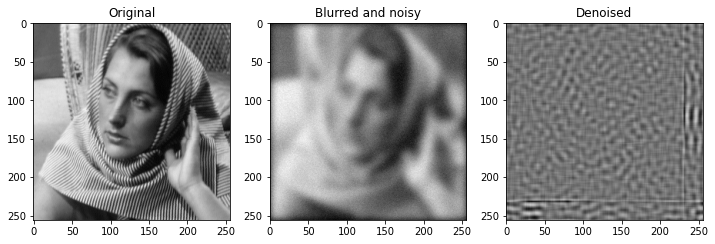

In [21]:
from skimage import data, color
from skimage.metrics import peak_signal_noise_ratio
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal


# Load the image
img = tiff.imread('./images/barbara.tif')

# Define the blur kernel
kernel_size = 25
sigma_kernel = 5
kernel = np.outer(signal.gaussian(kernel_size, sigma_kernel), signal.gaussian(kernel_size, sigma_kernel))

# Normalize the kernel to have unit sum
kernel = kernel / np.sum(kernel)

# Simulate blurring and noisy degradation
y = signal.convolve2d(img, kernel, mode='same')
y = y + np.random.normal(scale=5, size=y.shape)

# Set the parameters for PnP ADMM
alpha = 0.01
rho = 0.5
maxitr = 100

# Run the PnP ADMM algorithm
x_hat = deblur_pnp_admm(y, kernel, 5, alpha, rho, maxitr)

# Compute and print the PSNR of the reconstructed image
psnr = peak_signal_noise_ratio(img, np.real(x_hat))
print(f'PSNR = {psnr:.2f}')

# Display the results
fig, axs = plt.subplots(1, 3, figsize=(12, 6))
axs[0].imshow(img, cmap='gray')
axs[0].set_title('Original')
axs[1].imshow(y, cmap='gray')
axs[1].set_title('Blurred and noisy')
axs[2].imshow(np.real(x_hat), cmap='gray')
axs[2].set_title('Denoised')
plt.show()



## Question 12

In [22]:
import numpy as np
import scipy.optimize as opt

img = tiff.imread('./images/barbara.tif')
height, width = img.shape
max_freq = min(height, width) // 2

def F(r, C, a, p):
    return C * (a + r) ** (-p)

def error_function(params, r_values, x_values):
    C, a, p = params
    F_values = F(r_values, C, a, p)
    return np.sum((F_values - x_values) ** 2)


max_freq_y = height // 2
max_freq_x = width // 2

freq_y = np.fft.fftfreq(height)[:max_freq_y]
freq_x = np.fft.fftfreq(width)[:max_freq_x]
freq_mesh = np.sqrt(np.add.outer(freq_y ** 2, freq_x ** 2))
x_values = np.abs(np.fft.fft2(img))[:max_freq_y, :max_freq_x]

initial_guess = [1, 1, 2]  # Initial guess for the parameters C, a, and p
result = opt.minimize(error_function, initial_guess, args=(freq_mesh, x_values))
C, a, p = result.x


<ipython-input-22-251f16e9c9c8>:9: RuntimeWarning: invalid value encountered in power
  return C * (a + r) ** (-p)
<ipython-input-22-251f16e9c9c8>:9: RuntimeWarning: overflow encountered in power
  return C * (a + r) ** (-p)
/usr/local/lib/python3.9/dist-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
<ipython-input-22-251f16e9c9c8>:9: RuntimeWarning: invalid value encountered in power
  return C * (a + r) ** (-p)
<ipython-input-22-251f16e9c9c8>:9: RuntimeWarning: invalid value encountered in power
  return C * (a + r) ** (-p)


In [23]:
result.x
# This is failed as p is not even equal to 1 or 2.

array([ 510.88734801, -896.02403817,  -68.81768722])

### Question 11

In [24]:
import numpy as np
from scipy.ndimage import gaussian_filter

def simulate_degradation(image, h_stddev, noise_stddev):
    blurred_image = gaussian_filter(image, h_stddev)
    noisy_image = blurred_image + np.random.normal(0, noise_stddev, blurred_image.shape)
    return noisy_image

image = tiff.imread('./images/barbara.tif')
h_stddev = 5
noise_stddev = 5
degraded_image = simulate_degradation(image, h_stddev, noise_stddev)


In [25]:
def create_gaussian_kernel(image_shape, std_dev):
    size = int(6 * std_dev) 
    size += 1 if size % 2 == 0 else 0  # Ensure the kernel size is an odd number

    ax = np.arange(-size // 2 + 1., size // 2 + 1.)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2. * std_dev**2))
    kernel /= np.sum(kernel)
    
    padded_kernel = np.zeros(image_shape)
    padded_kernel[:size, :size] = kernel
    return padded_kernel


def prox_data_fitting(z, alpha, h_stddev, noisy_image, sigma):
    h = create_gaussian_kernel(z.shape, h_stddev)
    hhat = np.fft.fft2(h)
    zhat = np.fft.fft2(z)
    noisy_image_hat = np.fft.fft2(noisy_image)
    khat = (alpha * np.conj(hhat) * noisy_image_hat) / (alpha * np.abs(hhat) ** 2 + sigma ** 2)
    prox = np.fft.ifft2(khat).real
    return prox



In [26]:
from skimage.restoration import denoise_tv_chambolle

def prox_tv(z, weight):
    return denoise_tv_chambolle(z, weight=weight, multichannel=False)


def pnp_admm(image, h_stddev, noise_stddev, alpha, rho, iterations):
    image = image.astype(np.float64)  # Convert the image to float64
    y = image + noise_stddev * np.random.randn(*image.shape)  # Add Gaussian noise
    x = np.zeros_like(y)
    z = np.zeros_like(y)
    u = np.zeros_like(y)

    for _ in range(iterations):
        x = prox_data_fitting(z - u, alpha, h_stddev, y, noise_stddev)
        z = prox_tv(x + u, 1 / rho)
        u = u + x - z

    return x


alpha = 1
rho = 1
iterations = 30

reconstructed_image = pnp_admm(degraded_image, h_stddev, noise_stddev, alpha, rho, iterations)


<ipython-input-26-3affd6a046a7>:4: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  return denoise_tv_chambolle(z, weight=weight, multichannel=False)


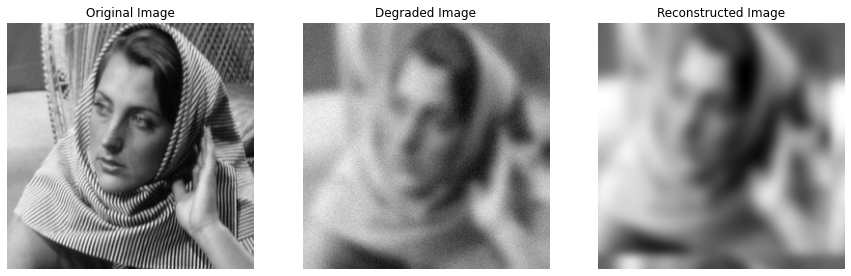

In [27]:
import matplotlib.pyplot as plt

def display_images(original, degraded, reconstructed):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(original, cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(degraded, cmap='gray')
    axes[1].set_title('Degraded Image')
    axes[1].axis('off')

    axes[2].imshow(reconstructed, cmap='gray')
    axes[2].set_title('Reconstructed Image')
    axes[2].axis('off')

    plt.show()

display_images(image, degraded_image, reconstructed_image)


In [28]:
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio, structural_similarity

mse = mean_squared_error(image, reconstructed_image)
psnr = peak_signal_noise_ratio(image, reconstructed_image, data_range=image.max() - image.min())
ssim = structural_similarity(image, reconstructed_image, data_range=image.max() - image.min())

print(f"MSE: {mse:.4f}")
print(f"PSNR: {psnr:.4f} dB")
print(f"SSIM: {ssim:.4f}")


MSE: 17299.5902
PSNR: 3.9809 dB
SSIM: 0.0245


## PnP ISTA


The Plug & Play ISTA algorithm presented in the lecture (Xu et al 2020) seeks to solve 

$$ \hat{x} = \arg\min_x F(x) + \gamma G(x) $$

of equivalently (for $\gamma = \sigma^2/\alpha$):

$$ \hat{x} = \arg\min_x \alpha F(x) + \sigma^2 G(x) $$

by running the following splitting scheme

* $v_k = x_k - \nabla(\alpha F)(x_k)$         (gradient descent step)
* $x_{k+1} = \prox_{\sigma^2 G}(v_k) = D_{\delta\sigma^2}(v_k)$   (proximal descent step)

Convergence is ensured as long as 

* $D_{\sigma^2}$ is an MMSE denoiser and
* $\alpha < 1 / Lip(\nabla F)$



**Question 13:**

complete the code below to compute the pnp ista algorithm

find the condition on $\gamma$ to garantee the convergence of PnP ISTA

find the optimal $\gamma$ for $\sigma = 40, 15, 5$

does it satisfy the convergence condition ?

For which $\sigma$ do you obtain the best reconstruction ?



In [29]:
def ista(gradF,proxG,init,**opts):
    """
    ISTA - min_x F(x) + G(x) by Proximal-gradient splitting

    v_k     = x_k - gradF(x_k)
    x_{k+1} = proxG(v_k)

    Convergence Condition: delta = 1 < 1/ Lip(gradF)

    Inputs:
        :gradF      gradient of F
        :proxG      Proximal operator of G
        :init       Initial value of x
        :delta      gradient descent step (default 1)
    Optional inputs
        :maxitr     default 50
        :verbose    default 1 (show messages)
    Outputs
        :x          minimizer
    """

    """ Process parameters. """
    maxitr = opts.get('maxitr', 50)
    verbose = opts.get('verbose', 1)
    monitor  = opts.get('monitor', None)  # debugging messages


    """ Initialization. """

    n = init.size  # == np.prod(init.shape), i.e. number of elements in ndarray

    x = np.copy(init)
    v = np.zeros_like(init, dtype=np.float64)

    """ Main loop. """

    for i in range(maxitr):

        # record the variables in the current iteration
        x_old = np.copy(x)
        v_old = np.copy(v)

        """ gradient descent step. """

        v = x - gradF(x, y, alpha=alpha, s=sigma/2)

        """ proximal descent step. """

        x = proxG(v)

        """ Monitors """

        if verbose :
            print("i = {},\t fpr = {}".format(i+1, np.linalg.norm(x-x_old)/np.linalg.norm(x)))


    """ Get restored image. """
    return x



def grad_datafit_gaussian_denoising(x, y, alpha=1.0, s=1.0, sigma=1.0):
    v = np.copy((x-y)*alpha/(s**2))
    return v


#gradF = lambda x : grad_datafit_gaussian_denoising(x, noisy, alpha, delta, sigma_noise)


In [30]:
from scipy.signal import wiener


def denoise_wiener(y, **kwargs):
    """
    Wiener filter denoising function.

    Inputs:
        :y - the noisy image.
        :**kwargs - optional arguments for the Wiener filter (e.g. filter size).
    """
    return wiener(y, **kwargs)

In [31]:
# Load the original image
img = tiff.imread('./images/barbara.tif')

# Add Gaussian noise to the image
sigma = 40
noise = sigma * np.random.randn(*img.shape)
y = img + noise

# Compute the optimal alpha and gamma
n = img.size
alpha_opt = sigma**2 / np.sqrt(n) / 2
gamma_opt = sigma**2 / alpha_opt

# Run PnP ISTA to denoise the image
x_hat = ista(grad_datafit_gaussian_denoising, denoise_wiener, y, sigma=sigma, alpha=alpha_opt, maxitr=100, verbose=1)


i = 1,	 fpr = 0.2425802241629539
i = 2,	 fpr = 0.05870053692617785
i = 3,	 fpr = 0.02825046436680165
i = 4,	 fpr = 0.01842100812158376
i = 5,	 fpr = 0.01354000864002167
i = 6,	 fpr = 0.010841908257068773
i = 7,	 fpr = 0.009007914769288408
i = 8,	 fpr = 0.007773088254802033
i = 9,	 fpr = 0.006952216698905702
i = 10,	 fpr = 0.006227041243771781
i = 11,	 fpr = 0.005565632765350311
i = 12,	 fpr = 0.005037105832560272
i = 13,	 fpr = 0.004689212344922218
i = 14,	 fpr = 0.004346316427244864
i = 15,	 fpr = 0.004048139434119919
i = 16,	 fpr = 0.0037922098272061546
i = 17,	 fpr = 0.003545762647491177
i = 18,	 fpr = 0.0033533101366596454
i = 19,	 fpr = 0.0032020310168611554
i = 20,	 fpr = 0.0030127676359923803
i = 21,	 fpr = 0.0028949190678689853
i = 22,	 fpr = 0.002758520366285706
i = 23,	 fpr = 0.0025919025856277057
i = 24,	 fpr = 0.0024849639286225506
i = 25,	 fpr = 0.0023978877046973565
i = 26,	 fpr = 0.0023182940578781977
i = 27,	 fpr = 0.0022431387421307353
i = 28,	 fpr = 0.0021767765908259

In [32]:
# Add Gaussian noise to the image
sigma = 15
noise = sigma * np.random.randn(*img.shape)
y = img + noise

# Compute the optimal alpha and gamma
n = img.size
alpha_opt = sigma**2 / np.sqrt(n) / 2
gamma_opt = sigma**2 / alpha_opt

# Run PnP ISTA to denoise the image
x_hat = ista(grad_datafit_gaussian_denoising, denoise_wiener, y, sigma=sigma, alpha=alpha_opt, maxitr=100, verbose=1)

i = 1,	 fpr = 0.10868372951157755
i = 2,	 fpr = 0.03287501664397535
i = 3,	 fpr = 0.01914962796027306
i = 4,	 fpr = 0.01390063746287141
i = 5,	 fpr = 0.011048322790934617
i = 6,	 fpr = 0.009036415830709736
i = 7,	 fpr = 0.00760950135489529
i = 8,	 fpr = 0.006619948004889411
i = 9,	 fpr = 0.005787355726136766
i = 10,	 fpr = 0.00501480167176094
i = 11,	 fpr = 0.004432841777969045
i = 12,	 fpr = 0.003973659281108381
i = 13,	 fpr = 0.0036633337585061892
i = 14,	 fpr = 0.0033565841680783877
i = 15,	 fpr = 0.0030580451671147722
i = 16,	 fpr = 0.0028557598663703347
i = 17,	 fpr = 0.002617521294756274
i = 18,	 fpr = 0.002443784951011807
i = 19,	 fpr = 0.002286796581683466
i = 20,	 fpr = 0.0021253294620486216
i = 21,	 fpr = 0.0020098520153941156
i = 22,	 fpr = 0.0018962593731754619
i = 23,	 fpr = 0.0017511722022774735
i = 24,	 fpr = 0.0016496982704339144
i = 25,	 fpr = 0.0015623874127939665
i = 26,	 fpr = 0.0014790280383250266
i = 27,	 fpr = 0.00140201464394478
i = 28,	 fpr = 0.0013360412025217

In [33]:
# Add Gaussian noise to the image
sigma = 5
noise = sigma * np.random.randn(*img.shape)
y = img + noise

# Compute the optimal alpha and gamma
n = img.size
alpha_opt = sigma**2 / np.sqrt(n) / 2
gamma_opt = sigma**2 / alpha_opt

# Run PnP ISTA to denoise the image
x_hat = ista(grad_datafit_gaussian_denoising, denoise_wiener, y, sigma=sigma, alpha=alpha_opt, maxitr=100, verbose=1)

i = 1,	 fpr = 0.06082644273968572
i = 2,	 fpr = 0.02472787668727867
i = 3,	 fpr = 0.013723380938204759
i = 4,	 fpr = 0.008993720975740048
i = 5,	 fpr = 0.006603905639400236
i = 6,	 fpr = 0.005124150884104989
i = 7,	 fpr = 0.004021055326631687
i = 8,	 fpr = 0.0032768838873584415
i = 9,	 fpr = 0.002705933230415266
i = 10,	 fpr = 0.0022006138785453985
i = 11,	 fpr = 0.0018468866380575214
i = 12,	 fpr = 0.001599288008962538
i = 13,	 fpr = 0.0014009939435354279
i = 14,	 fpr = 0.0012512962594548819
i = 15,	 fpr = 0.001145187268893081
i = 16,	 fpr = 0.0010206799447517957
i = 17,	 fpr = 0.0009179080770067061
i = 18,	 fpr = 0.0008159486865116232
i = 19,	 fpr = 0.0007344249887305161
i = 20,	 fpr = 0.0006650321849799275
i = 21,	 fpr = 0.0006277563366497809
i = 22,	 fpr = 0.0005952435536085634
i = 23,	 fpr = 0.0005546282243186663
i = 24,	 fpr = 0.0005181817511377286
i = 25,	 fpr = 0.0004927474244205551
i = 26,	 fpr = 0.0004630068902203293
i = 27,	 fpr = 0.00043595492723268474
i = 28,	 fpr = 0.0004

<ipython-input-34-9f20752b2f3c>:27: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = metrics.peak_signal_noise_ratio(img, x_hat)
/usr/local/lib/python3.9/dist-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


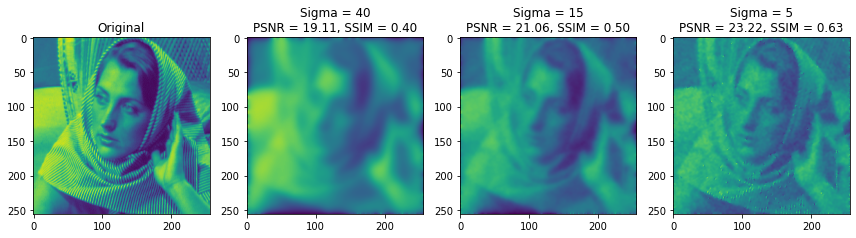

PSNR scores: [19.109071136375245, 21.063629726591895, 23.22448270219524]
SSIM scores: [0.4005439555873958, 0.5028662554819492, 0.6296498739235917]


In [34]:
import skimage.metrics as metrics
# Load the original image
img = tiff.imread('./images/barbara.tif')

# Add Gaussian noise to the image
sigma = 40
noise = sigma * np.random.randn(*img.shape)
y = img + noise #noisy image

# Set up a subplot for each value of sigma
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
axs[0].imshow(img)
axs[0].set_title('Original')
axs[1].imshow(y)
axs[1].set_title('Noisy')

psnr_scores = []
ssim_scores = []

for i, sigma in enumerate([40, 15, 5]):
    # Run PnP ISTA to denoise the image
    alpha_opt = sigma**2 / np.sqrt(n) / 2
    gamma_opt = sigma**2 / alpha_opt
    x_hat = ista(grad_datafit_gaussian_denoising, denoise_wiener, y, sigma=sigma, alpha=alpha_opt, maxitr=100, verbose=0)

    # Compute the PSNR and SSIM
    psnr = metrics.peak_signal_noise_ratio(img, x_hat)
    ssim = metrics.structural_similarity(img, x_hat)

    psnr_scores.append(psnr)
    ssim_scores.append(ssim)

    # Display the denoised image
    axs[i+1].imshow(x_hat)
    axs[i+1].set_title(f'Sigma = {sigma}\nPSNR = {psnr:.2f}, SSIM = {ssim:.2f}')

plt.tight_layout()
plt.show()

print('PSNR scores:', psnr_scores)
print('SSIM scores:', ssim_scores)


## ANSWER
After comparing fpr's for $\sigma=40,15,5$ I noticed that values were very close then I decided to search for other metrics and vizuliaze the results. But I still didn't get any difference. So I conclude that they all provide very small fpr's. 
